In [1]:
import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from dsa_analysis import load_config, visualize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
import main
from main import RNNLayer
import ast
import DSA
import copy
from notebooks.utils_mamba import *
%load_ext autoreload
%autoreload 2

### Load config

In [2]:
config = load_config("../config.yaml")
taskset = "PDM"

In [3]:
# Define font sizes and styles for the plot
SIZE_DEFAULT = 8
SIZE_LARGE = 10
plt.rc("font", family="Arial")  # controls default font
plt.rc("font", weight="normal")  # controls default font
plt.rc("font", size=SIZE_DEFAULT)  # controls default text sizes
plt.rc("axes", titlesize=SIZE_LARGE)  # fontsize of the axes title
plt.rc("axes", labelsize=SIZE_LARGE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels

### Get dissimilarities

#### Computation dynamics

In [4]:
path = f"../data/dissimilarities/mamba/{taskset}/"
df = get_dataframe(path, taskset)

In [5]:
groups_selected = [
    "pretrain_basic_frozen",
    "pretrain_anti_frozen",
    "pretrain_delay_frozen",
    "pretrain_basic_anti_frozen",
    "pretrain_basic_delay_frozen",
]
# map all the groups in groups_selected to pretrain_partial
df_selected = df.copy()
df_selected["group2"] = df_selected["group2"].apply(
    lambda x: "pretrain_partial" if x in groups_selected else x
)
df_selected["group1"] = df_selected["group1"].apply(
    lambda x: "pretrain_partial" if x in groups_selected else x
)
groups_base = ["master"]
groups_selected = ["pretrain_partial", "pretrain_frozen", "pretrain_unfrozen"]
df_selected = df_selected[
    df_selected["group1"].isin(groups_base)
    & df_selected["group2"].isin(groups_selected)
]

In [6]:
def discriminate_df(df_selected, groups_base, criteria):
    for measure in measures:
        fig, ax = plt.subplots(
            nrows=1, ncols=1, figsize=(20, 10), sharex=True, sharey=True
        )

        # Iterate over each group pair
        for group in groups_base:
            # ax = axes[groups_base.index(group)]

            # Prepare palette dictionary for hue levels
            hue_palette = {
                hue: color_mapping.get(hue, "gray")
                for hue in df_selected["group2"].unique()
            }

            # Plot a violin plot for the dissimilarity distribution
            sns.violinplot(
                data=df_selected[
                    (df_selected["group1"] == group)
                    & (df_selected["measure"] == measure)
                ],
                x=criteria,
                y="dissimilarity",
                hue="group2",
                ax=ax,
                inner="quart",
                palette=hue_palette,
            )
            ax.set_title(f"{group}", fontsize=8)
            ax.set_xlabel("")
            ax.set_ylabel("")

        # Adjust layout
        plt.suptitle(
            f"Distribution of Dissimilarities Across Groups for Metric : {measure}",
            fontsize=16,
        )
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

In [7]:
df_selected, models_trained_per_group = select_df(df)

In [8]:
groups_selected = [
    "pretrain_basic_frozen",
    "pretrain_anti_frozen",
    "pretrain_delay_frozen",
    "pretrain_basic_anti_frozen",
    "pretrain_basic_delay_frozen",
]
# map all the groups in groups_selected to pretrain_partial
df_grouped = df_selected.copy()
df_grouped["group2"] = df_grouped["group2"].apply(
    lambda x: "pretrain_partial" if x in groups_selected else x
)
df_grouped["group1"] = df_grouped["group1"].apply(
    lambda x: "pretrain_partial" if x in groups_selected else x
)
groups_base = ["master"]
groups_selected = [
    "untrained",
    "master_frozen",
    "pretrain_partial",
    "pretrain_frozen",
    "pretrain_unfrozen",
]
df_grouped = df_grouped[
    df_grouped["group1"].isin(groups_base) & df_grouped["group2"].isin(groups_selected)
]

In [9]:
df_grouped["group2"].unique()

array(['untrained', 'master_frozen', 'pretrain_partial',
       'pretrain_frozen', 'pretrain_unfrozen'], dtype=object)

In [17]:
from tkinter import font
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import textwrap

# Define font sizes and styles for the plot
SIZE_DEFAULT = 18
SIZE_LARGE = 20
plt.rc("font", family="Arial")  # controls default font
plt.rc("font", weight="normal")  # controls default font
plt.rc("font", size=SIZE_DEFAULT)  # controls default text sizes
plt.rc("axes", titlesize=SIZE_LARGE)  # fontsize of the axes title
plt.rc("axes", labelsize=SIZE_LARGE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels

# Dictionary to map internal group names to display names
group_mapping_names = {
    "master": "Master",
    "untrained": "Untrained",
    "master_frozen": "Master & Frozen",
    "pretrain_partial": "Partial Pretraining",
    "pretrain_basic_frozen": "Pretrain Basic\nFrozen",
    "pretrain_frozen": "Full Pretraining",
    "pretrain_unfrozen": "Full Pretraining\n& Unfrozen",
}
name_measures_plot = {"cka": "CKA", "procrustes": "Procrustes", "dsa": "DSA"}

color_mapping_metrics = {
    "dsa": "#7B1E3C",  # Nice green (medium green)
    "cka": "#8D99AE",  # Light shade of blue (sky blue)
    "procrustes": "#2B2F42",  # Darker shade of blue (medium blue)
}


def wrap_group_name(group_name, max_width=11):
    return "\n".join(textwrap.wrap(group_name, width=max_width))


def discriminate_df_with_error_bars(df_selected, groups_base):
    measures = ["dsa", "cka", "procrustes"]

    for measure in measures:
        # Create a new figure for each measure
        fig, ax = plt.subplots(figsize=(8, 6), dpi=500)

        for group in groups_base:
            data_to_plot = df_selected[
                (df_selected["group1"] == group) & (df_selected["measure"] == measure)
            ]

            hue_palette = [
                color_mapping.get(hue, "gray")
                for hue in data_to_plot["group2"].unique()
            ]

            groups = data_to_plot["group2"].unique()
            data = [
                data_to_plot[data_to_plot["group2"] == g]["dissimilarity"].values
                for g in groups
            ]

            box = ax.boxplot(
                data,
                positions=np.arange(len(groups)) * 0.8 - 1.25,
                patch_artist=True,
                widths=0.15,
                showfliers=False,
                medianprops=dict(color="black", linewidth=2),
                whiskerprops=dict(linewidth=1),
                capprops=dict(linewidth=1),
                boxprops=dict(linewidth=1, alpha=0.7),
            )

            for patch, color in zip(box["boxes"], hue_palette):
                patch.set_facecolor(color)

            means = [np.mean(d) for d in data]
            errors = [np.std(d) / np.sqrt(len(d)) for d in data]
            x_positions = np.arange(len(groups)) * 0.8 - 1.25 + 0.2

            for j, (mean, error, x_pos) in enumerate(zip(means, errors, x_positions)):
                ax.errorbar(
                    x=x_pos,
                    y=mean,
                    yerr=error,
                    fmt="o",
                    color=box["boxes"][j].get_facecolor(),
                    ecolor=box["boxes"][j].get_facecolor(),
                    elinewidth=2,
                    capsize=4,
                    capthick=2,
                    linestyle="none",
                )

        ax.set_xlabel("")
        ax.set_xticks(np.arange(len(groups)) * 0.8 - 1.25)
        ax.set_xticklabels(
            [wrap_group_name(group_mapping_names.get(g, g)) for g in groups],
            rotation=0,
            fontsize=22,
        )

        # for tick_label, color in zip(ax.get_xticklabels(), hue_palette):
        #     tick_label.set_color(color)

        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_visible(False)

        ax.set_title(
            f"Mamba ({name_measures_plot[measure]})",
            color="black",
            pad=20,
            fontweight="bold",
        )

        ax.set_xlim([-1.5, len(groups) * 0.6 - 0.75])
        ax.set_ylabel("Dissimilarity to Master")

        plt.tight_layout()
        plt.show()


# Call the function (assuming df_selected and groups_base are defined)
# discriminate_df_with_error_bars(df_selected, groups_base)

In [21]:
from tkinter import font
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import textwrap

# Define font sizes and styles for the plot
SIZE_DEFAULT = 25
SIZE_LARGE = 30
plt.rc("font", family="Arial")  # controls default font
plt.rc("font", weight="normal")  # controls default font
plt.rc("font", size=SIZE_DEFAULT)  # controls default text sizes
plt.rc("axes", titlesize=SIZE_LARGE)  # fontsize of the axes title
plt.rc("axes", labelsize=SIZE_LARGE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels

# Dictionary to map internal group names to display names
group_mapping_names = {
    "master": "Master",
    "untrained": "Untrained",
    "master_frozen": "Master & Frozen",
    "pretrain_partial": "Partial Pretraining",
    "pretrain_basic_frozen": "Pretrain Basic\nFrozen",
    "pretrain_frozen": "Full Pretraining",
    "pretrain_unfrozen": "Full Pretraining\n& Unfrozen",
}
name_measures_plot = {"cka": "CKA", "procrustes": "Procrustes", "dsa": "DSA"}

color_mapping_metrics = {
    "dsa": "#7B1E3C",  # Nice green (medium green)
    "cka": "#8D99AE",  # Light shade of blue (sky blue)
    "procrustes": "#2B2F42",  # Darker shade of blue (medium blue)
}


def wrap_group_name(group_name, max_width=11):
    return "\n".join(textwrap.wrap(group_name, width=max_width))


def discriminate_df_with_error_bars(df_selected, groups_base):
    measures = ["dsa", "cka", "procrustes"]

    for measure in measures:
        # Create a new figure for each measure
        fig, ax = plt.subplots(figsize=(10, 6), dpi=500)

        for group in groups_base:
            data_to_plot = df_selected[
                (df_selected["group1"] == group) & (df_selected["measure"] == measure)
            ]

            hue_palette = [
                color_mapping.get(hue, "gray")
                for hue in data_to_plot["group2"].unique()
            ]

            groups = data_to_plot["group2"].unique()
            data = [
                data_to_plot[data_to_plot["group2"] == g]["dissimilarity"].values
                for g in groups
            ]

            box = ax.boxplot(
                data,
                positions=np.arange(len(groups)) * 0.8 - 1.25,
                patch_artist=True,
                widths=0.2,
                showfliers=False,
                medianprops=dict(color="black", linewidth=2),
                whiskerprops=dict(linewidth=1),
                capprops=dict(linewidth=1),
                boxprops=dict(linewidth=1, alpha=0.7),
            )

            for patch, color in zip(box["boxes"], hue_palette):
                patch.set_facecolor(color)

            means = [np.mean(d) for d in data]
            errors = [np.std(d) / np.sqrt(len(d)) for d in data]
            x_positions = np.arange(len(groups)) * 0.8 - 1.25 + 0.2

            for j, (mean, error, x_pos) in enumerate(zip(means, errors, x_positions)):
                ax.errorbar(
                    x=x_pos,
                    y=mean,
                    yerr=error,
                    fmt="o",
                    color=box["boxes"][j].get_facecolor(),
                    ecolor=box["boxes"][j].get_facecolor(),
                    elinewidth=2,
                    capsize=4,
                    capthick=2,
                    linestyle="none",
                )

        
        ax.set_xlabel("")
        ax.set_xticks(np.arange(len(groups)) * 0.8 - 1.25)
        ax.set_xticklabels(
            [wrap_group_name(group_mapping_names.get(g, g)) for g in groups],
            rotation=0,
            fontsize=22,
            )

        # for tick_label, color in zip(ax.get_xticklabels(), hue_palette):
        #     tick_label.set_color(color)
        # else:
        #     ax.set_xticks([])
        #     ax.set_xticklabels([])

        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_visible(False)

        # if measure == "dsa":
        #     ax.set_title(
        #         f"RNN ({name_measures_plot[measure]})",
        #         color="black",
        #         pad=20,
        #     )
        # else:
        ax.set_title(
            f"Mamba ({name_measures_plot[measure]})",
            color="black",
            pad=20,
            fontweight="bold",
        )

        # ax.set_xlim([-1.5, len(groups) * 0.6 - 0.75])
        ax.set_ylabel("Dissimilarity to Master")

        plt.tight_layout()
        plt.show()


# Call the function (assuming df_selected and groups_base are defined)
# discriminate_df_with_error_bars(df_selected, groups_base)

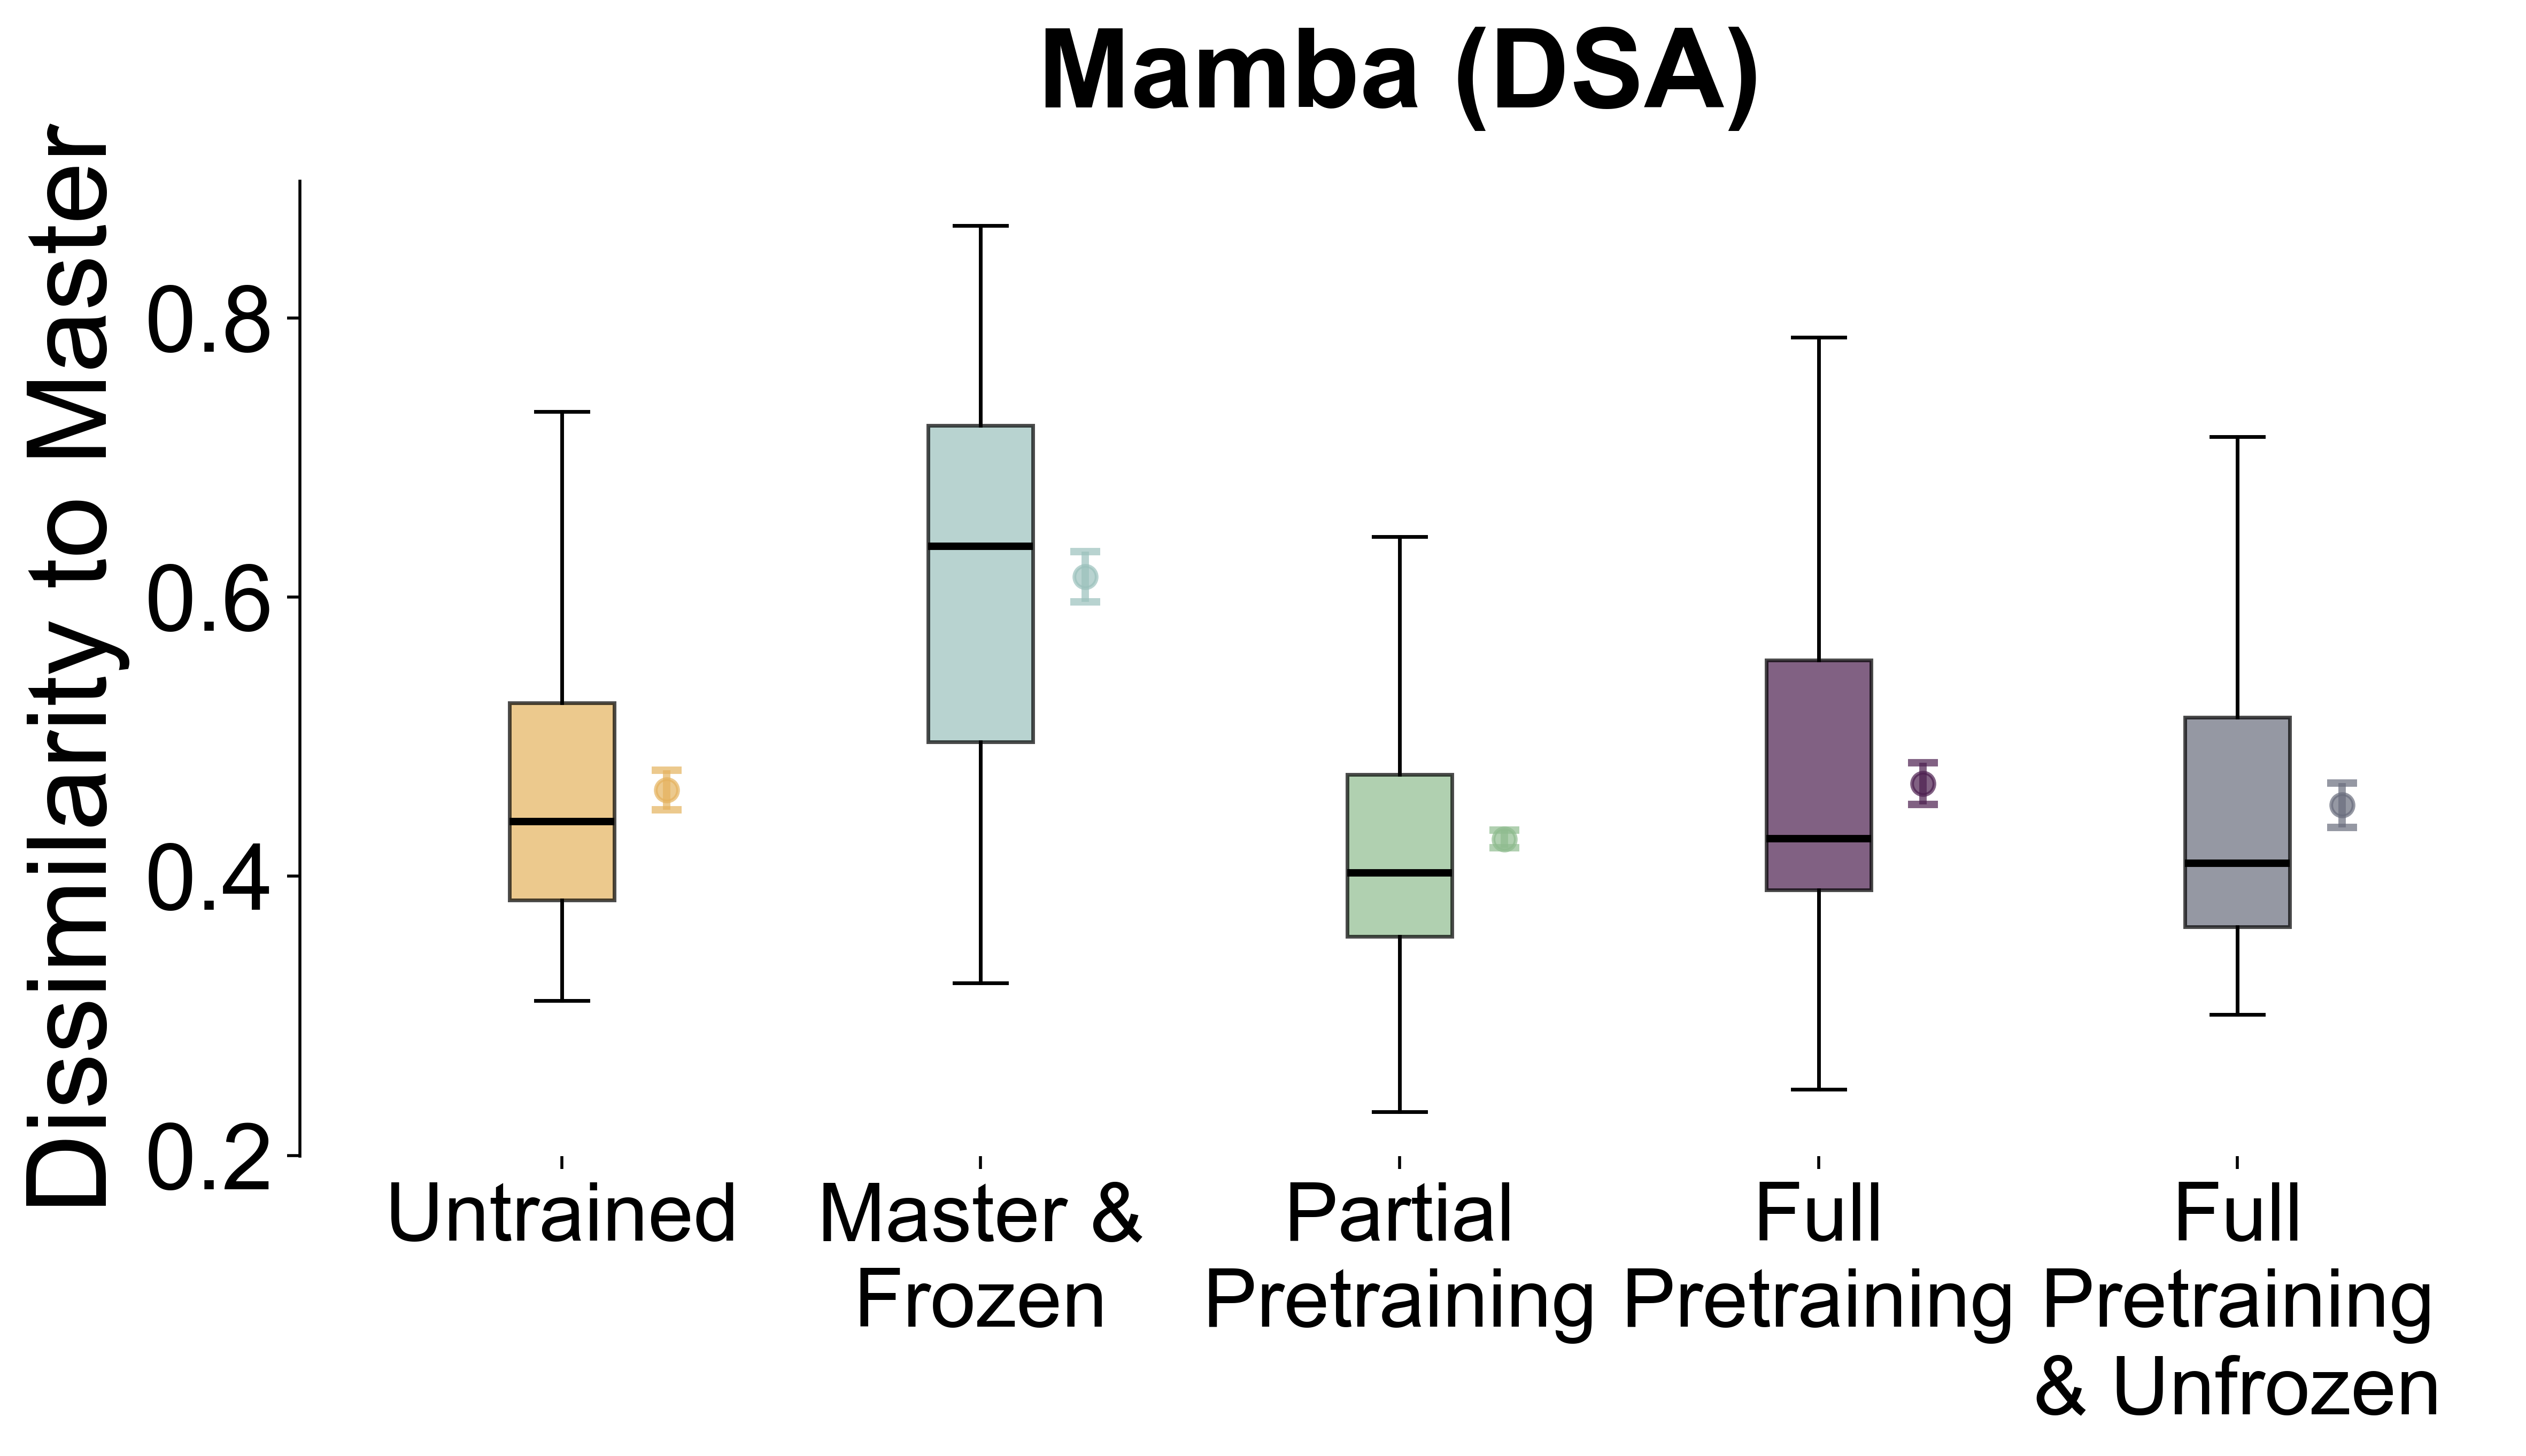

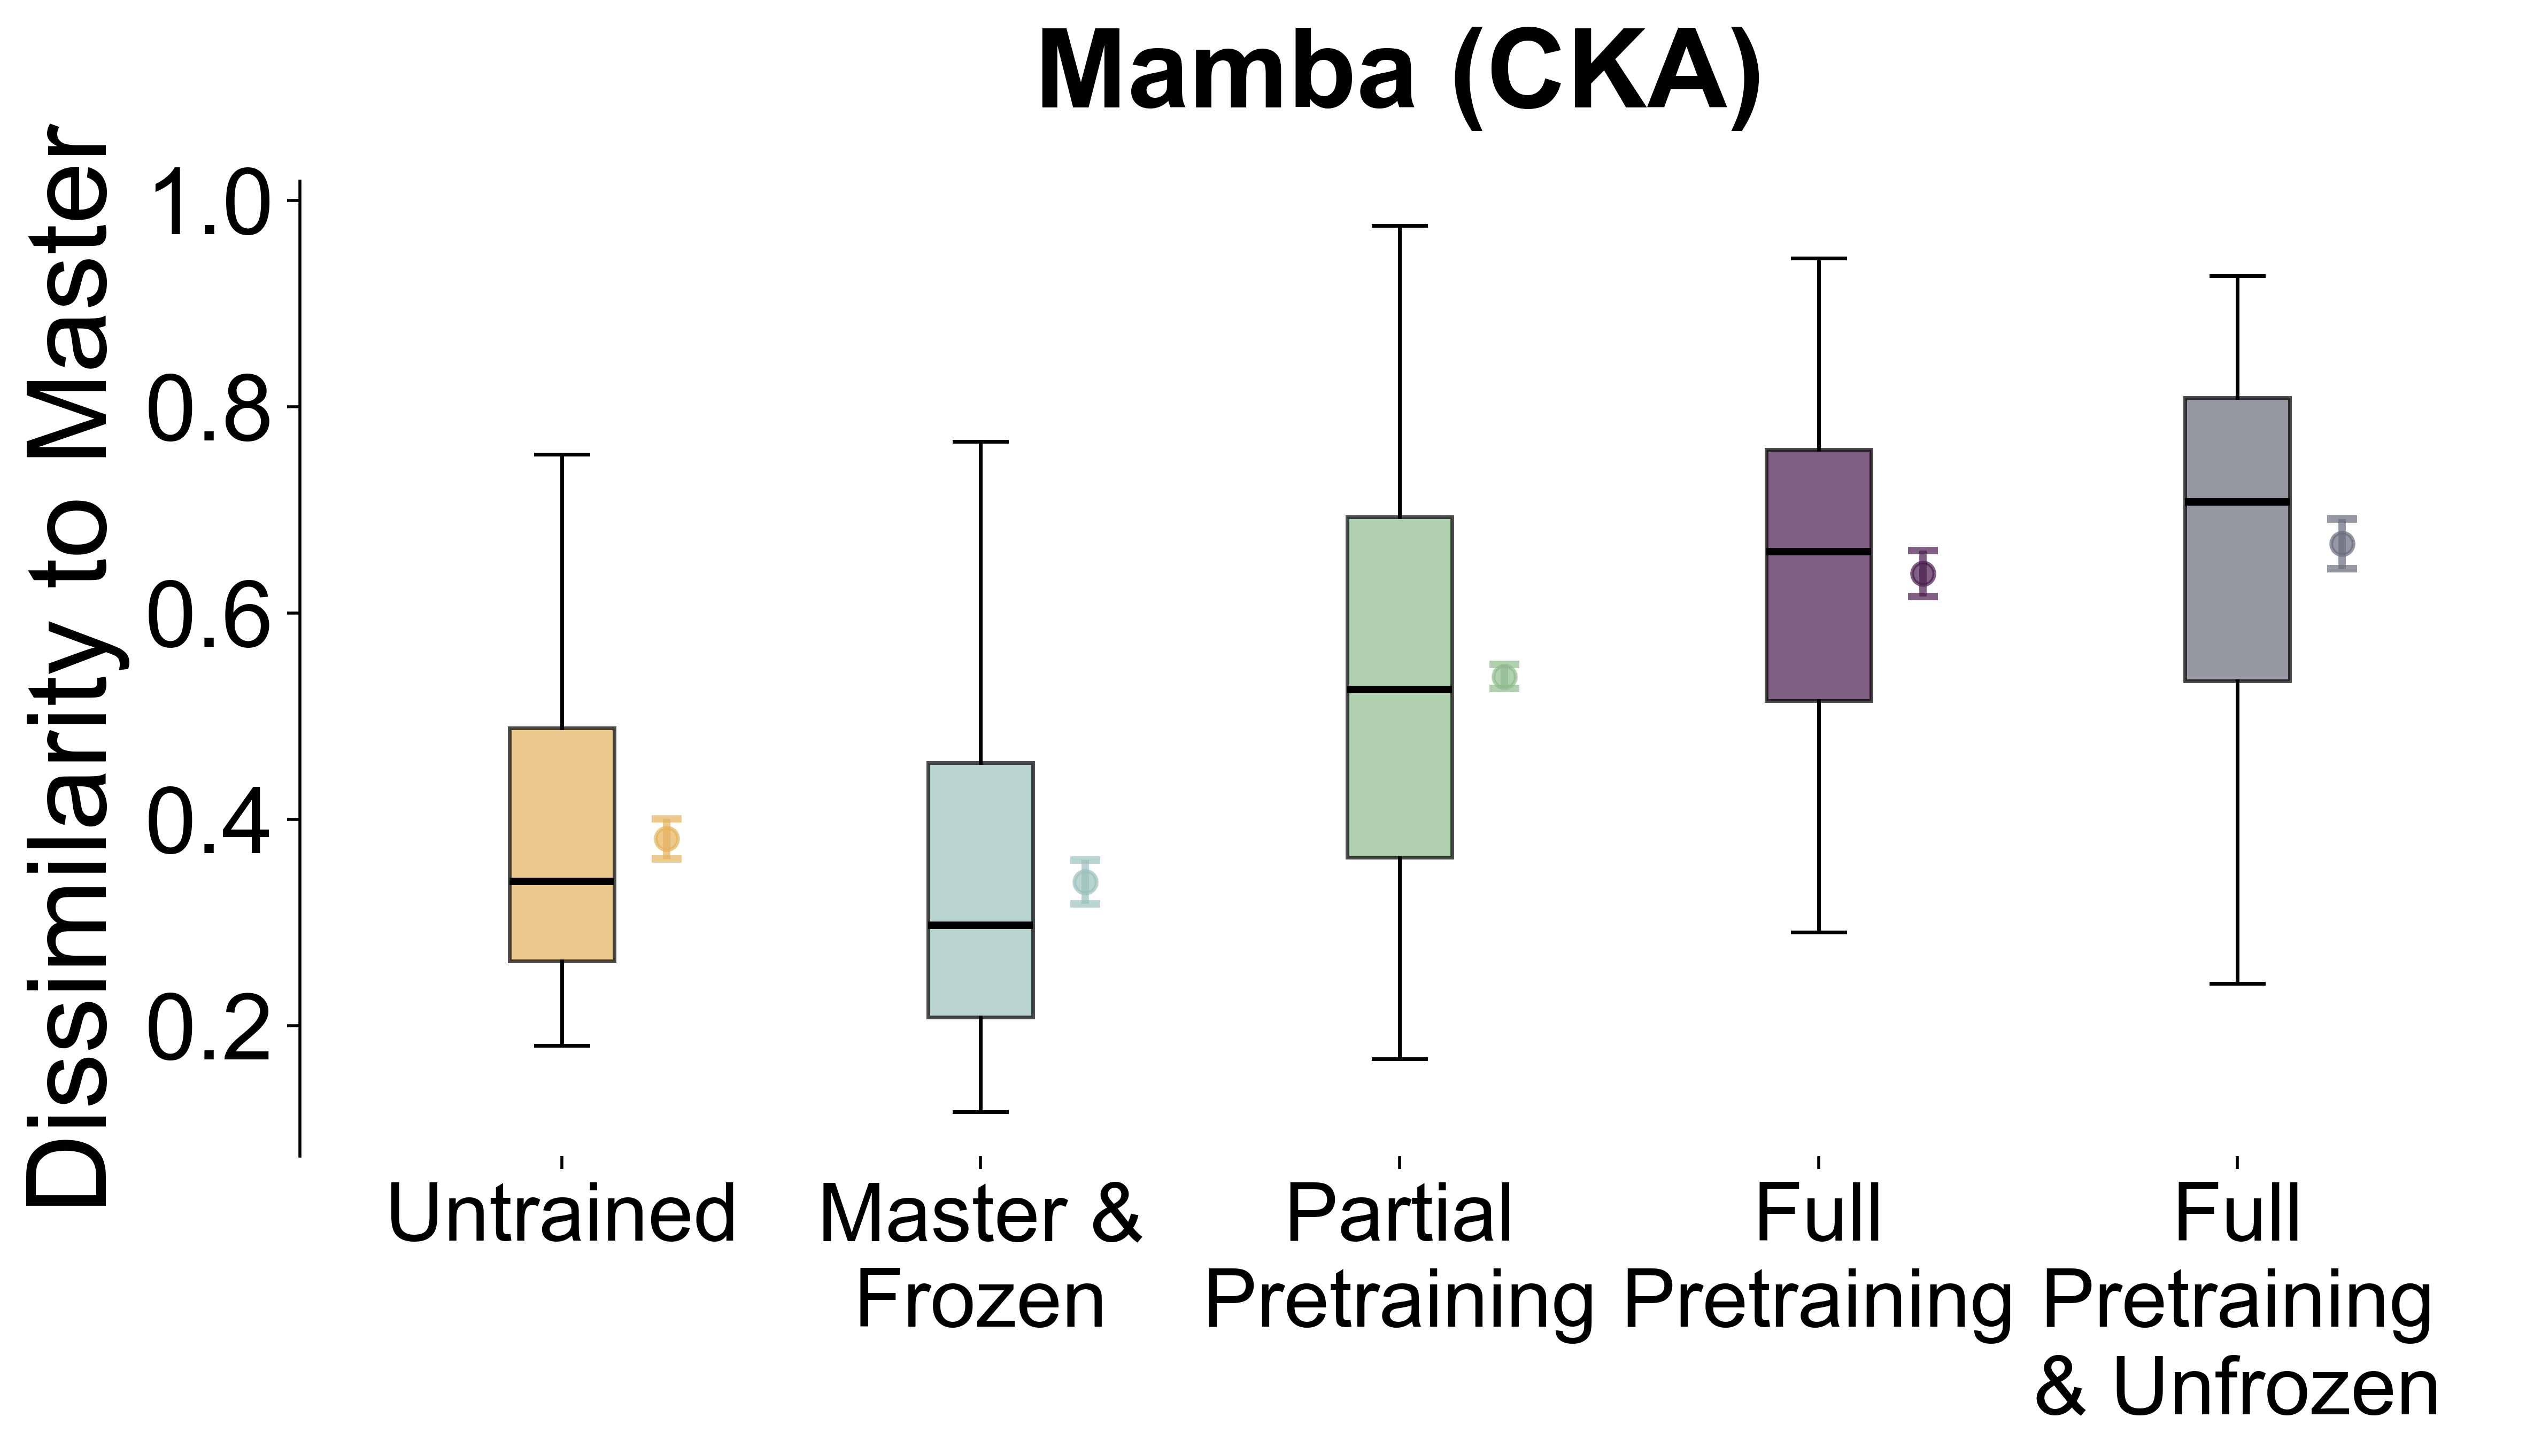

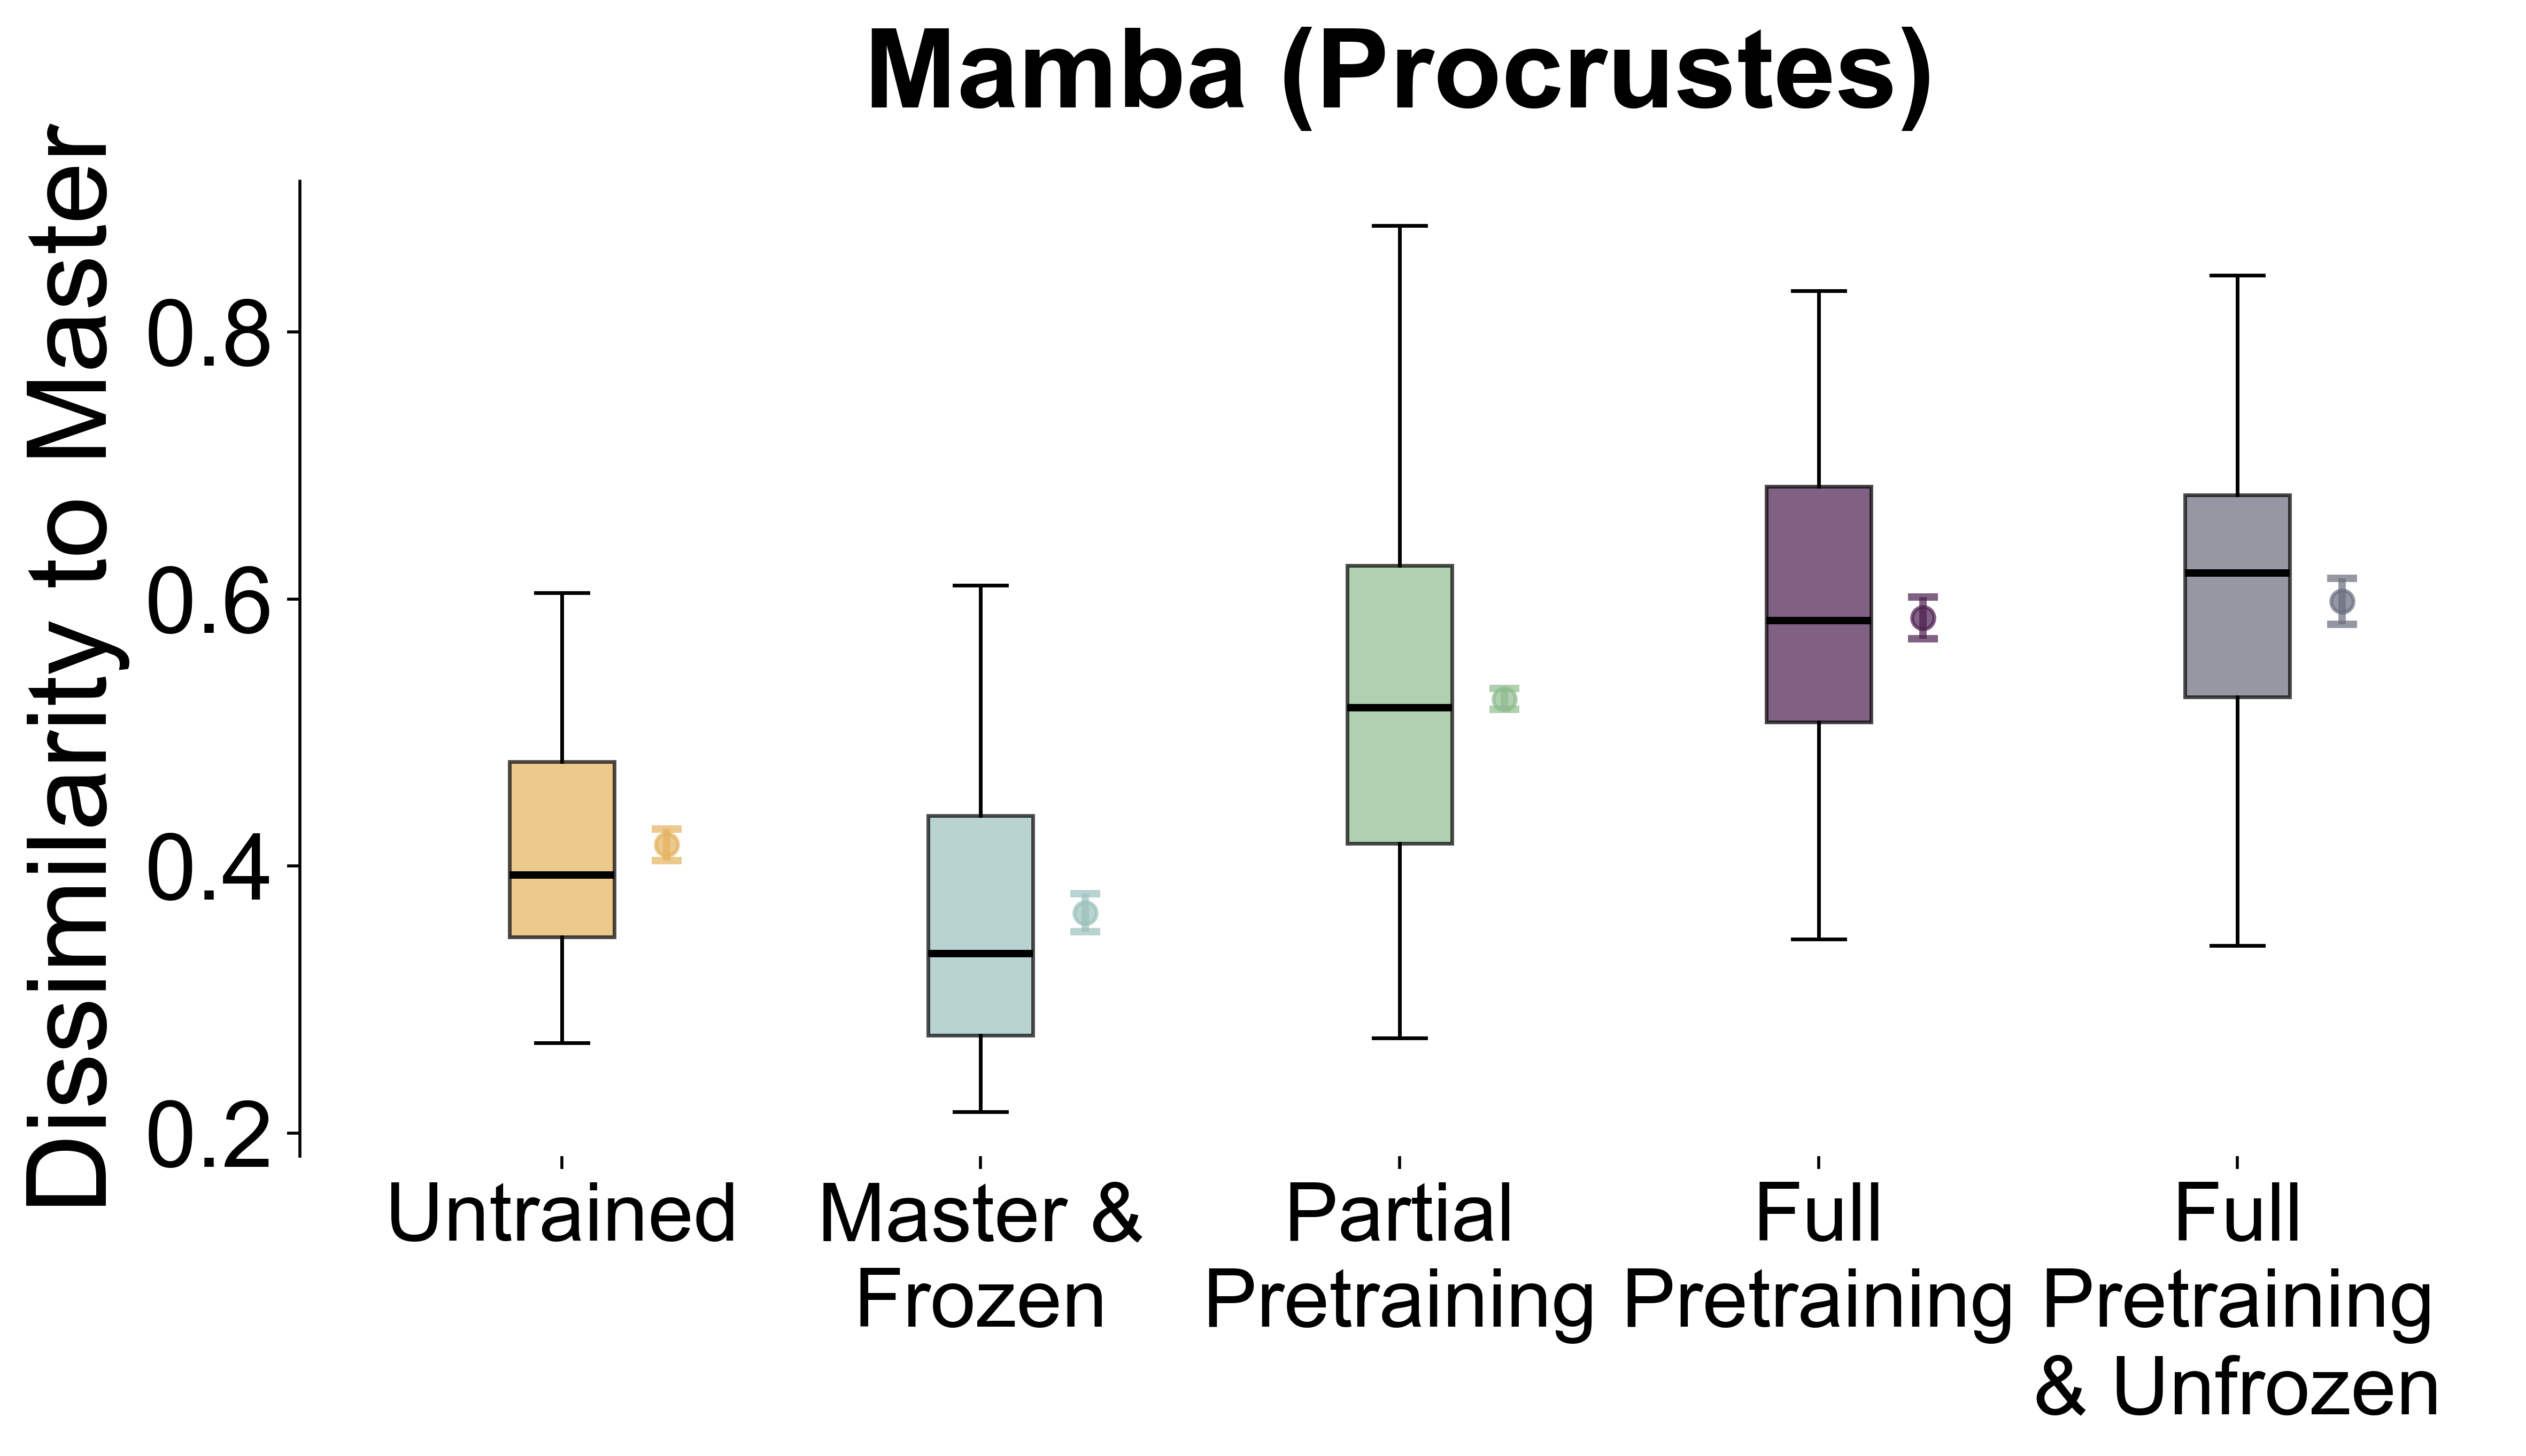

In [22]:
discriminate_df_with_error_bars(df_grouped, groups_base)

In [12]:
# Group by 'group1', 'group2', and 'measure', then calculate median dissimilarities
median_dissimilarities = (
    df_selected.groupby(["group1", "group2", "measure"])["dissimilarity"]
    .mean()
    .reset_index()
)

# Pivot the data to prepare it for the heatmap
pivot_table = median_dissimilarities.pivot_table(
    index="group1", columns="group2", values="dissimilarity"
)

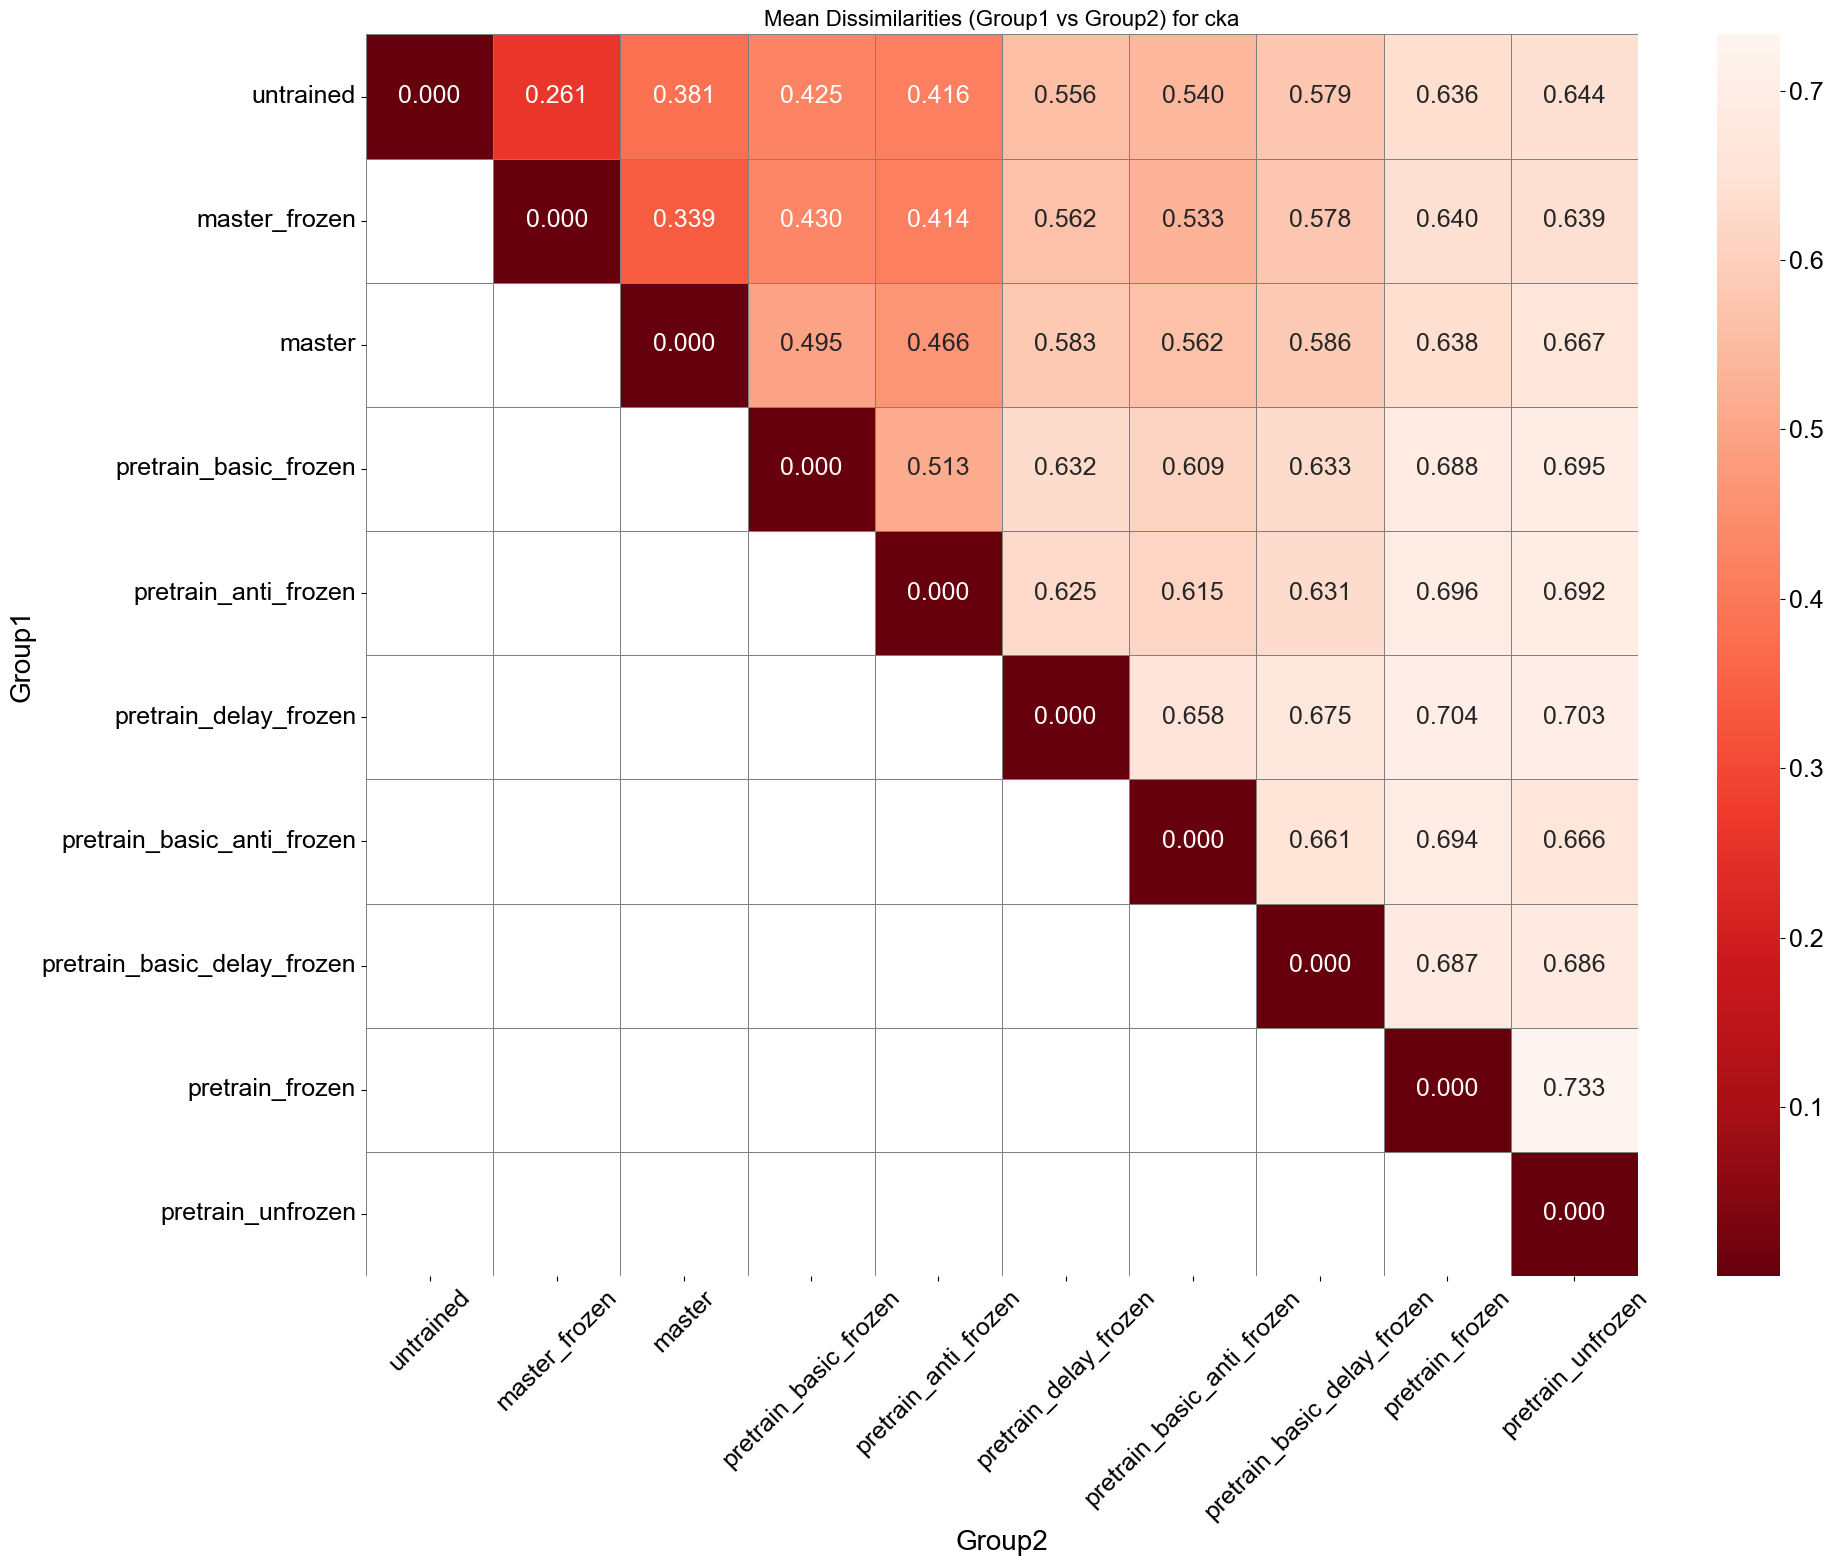

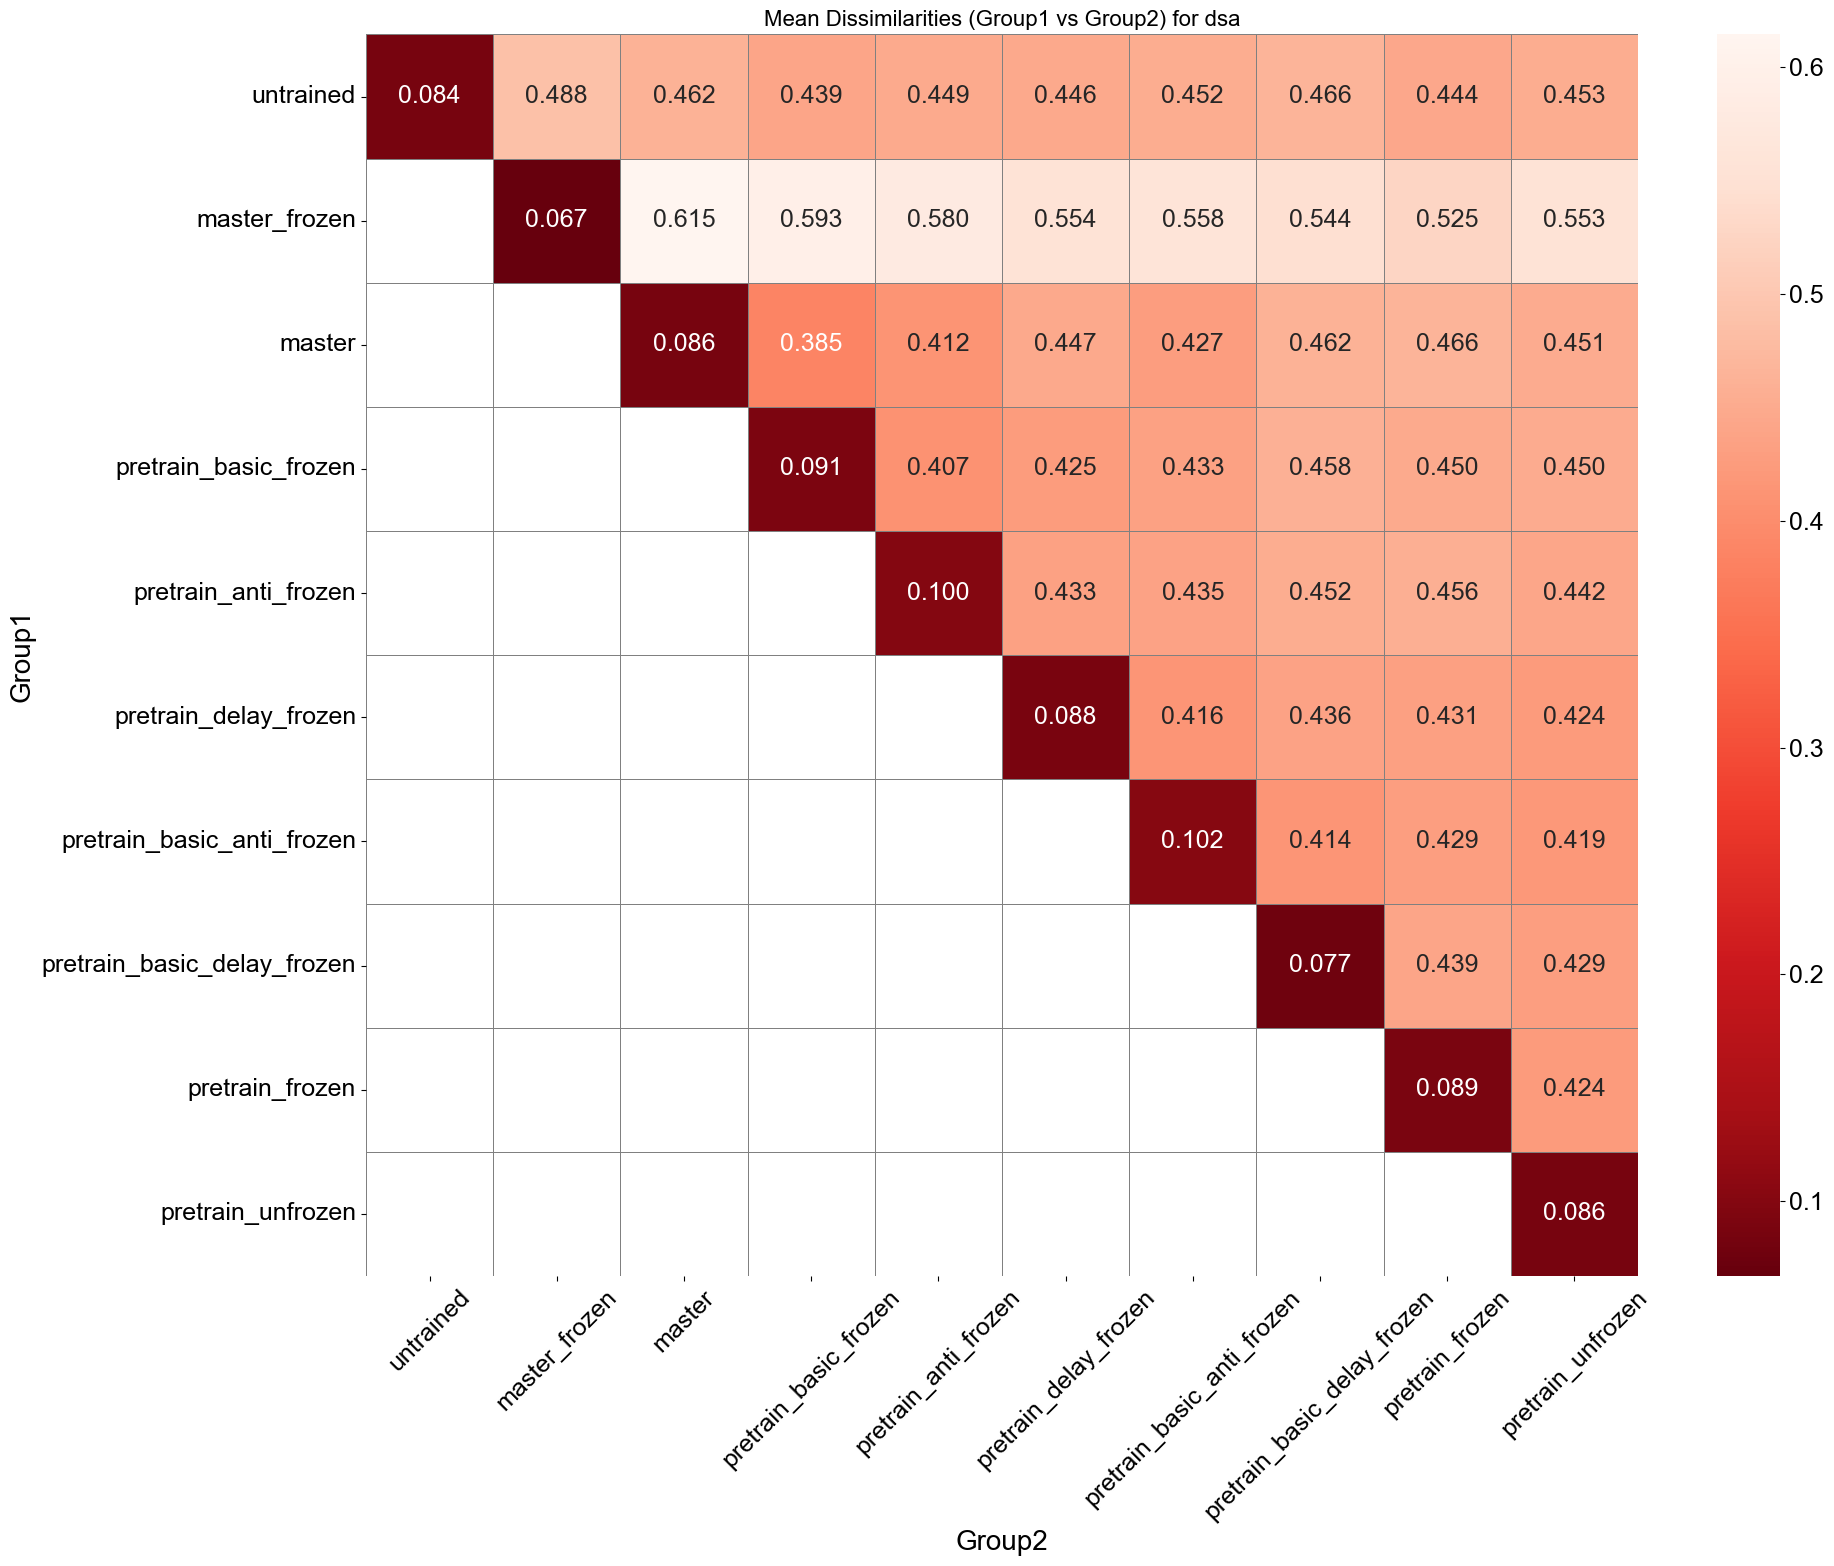

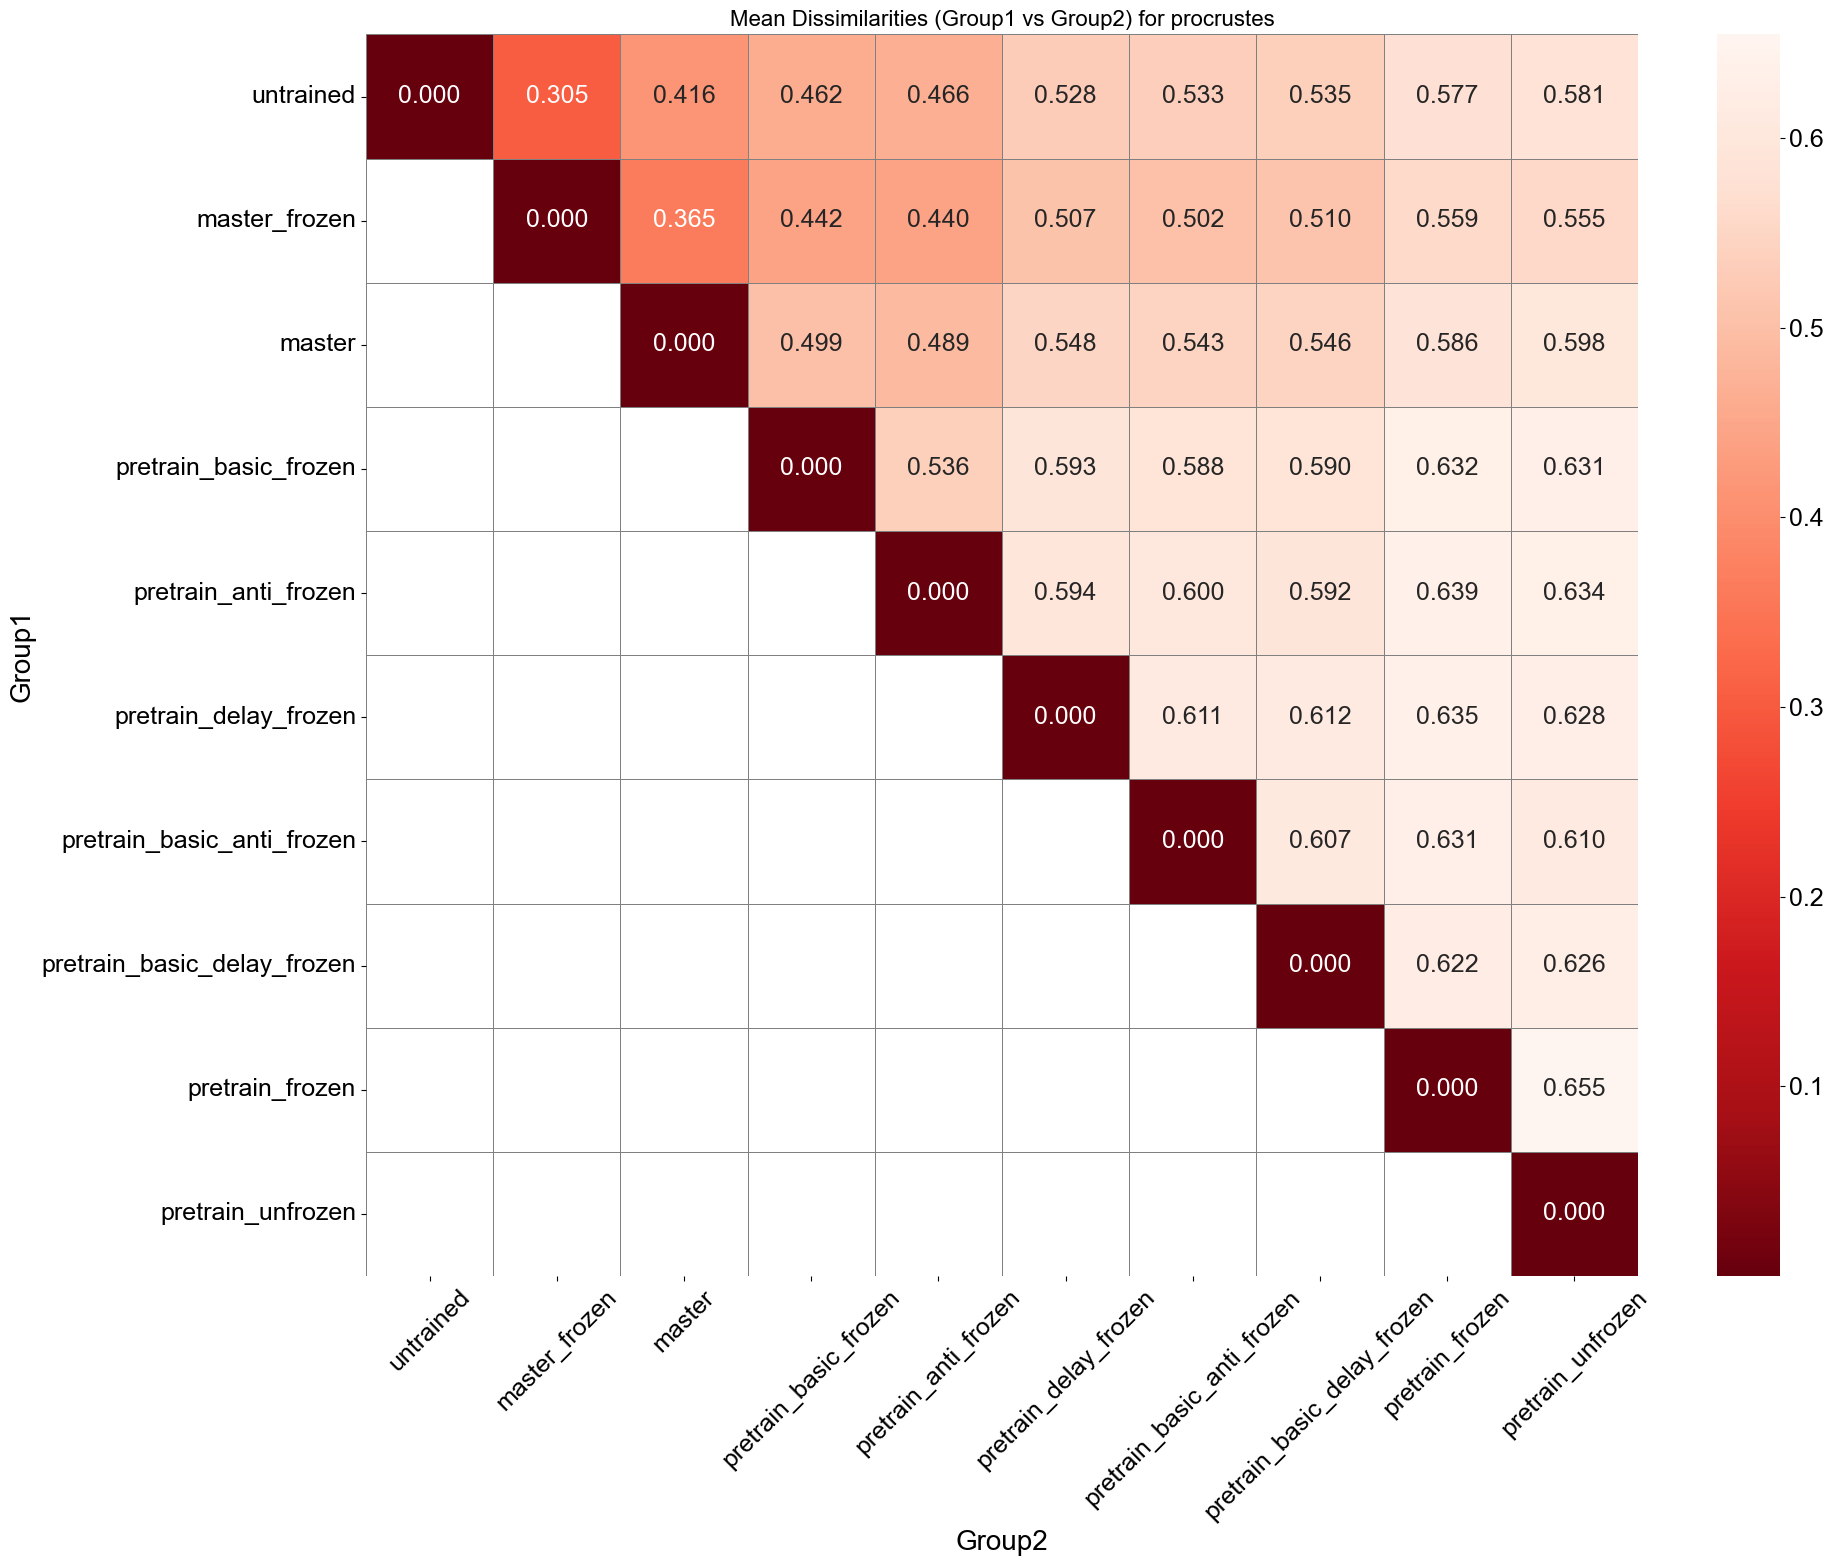

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming median_dissimilarities DataFrame is defined

# Define the desired order for groups
groups = [
    "untrained",
    "master_frozen",
    "master",
    "pretrain_basic_frozen",
    "pretrain_anti_frozen",
    "pretrain_delay_frozen",
    "pretrain_basic_anti_frozen",
    "pretrain_basic_delay_frozen",
    "pretrain_frozen",
    "pretrain_unfrozen",
]

# Unique measures
measures = df_selected["measure"].unique()

# Plot heatmap for each measure
for measure in measures:
    # Filter the pivot table for the specific measure
    measure_pivot = median_dissimilarities[
        median_dissimilarities["measure"] == measure
    ].pivot(index="group1", columns="group2", values="dissimilarity")

    # Reorder the rows and columns according to the specified groups
    measure_pivot = measure_pivot.reindex(index=groups, columns=groups)

    # Create a mask for the lower triangle (excluding the diagonal)
    mask = np.tril(np.ones_like(measure_pivot, dtype=bool), -1)

    # Create a heatmap
    # TODO : same scale for all metrics : Same min max for all metrics
    plt.figure(figsize=(20, 16))
    sns.heatmap(
        measure_pivot,
        annot=True,
        fmt=".3f",
        cmap="Reds_r",
        cbar=True,
        linewidths=0.5,
        linecolor="gray",
        mask=mask,  # Apply the mask to show only the upper triangle including the diagonal
    )
    plt.title(f"Mean Dissimilarities (Group1 vs Group2) for {measure}", fontsize=16)
    plt.xlabel("Group2")
    plt.ylabel("Group1")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [14]:
df_test = t_test_all_pairs(df_selected, "procrustes")

['untrained' 'master_frozen' 'master' 'pretrain_partial' 'pretrain_frozen'
 'pretrain_unfrozen']


In [15]:
df_test

,pairs,p_value,adjusted_p_value
0,"(untrained, master_frozen)",1.358852e-04,1.509835e-04
1,"(untrained, pretrain_partial)",1.148024e-16,1.913373e-16
2,"(untrained, pretrain_frozen)",1.031478e-26,2.062957e-26
3,"(untrained, pretrain_unfrozen)",2.791406e-27,6.978514e-27
4,"(master_frozen, untrained)",1.358852e-04,1.509835e-04
5,"(master_frozen, pretrain_partial)",2.781208e-31,9.270692e-31
6,"(master_frozen, pretrain_frozen)",9.489129e-35,4.744565e-34
7,"(master_frozen, pretrain_unfrozen)",4.692085e-35,4.692085e-34
8,"(pretrain_partial, untrained)",1.148024e-16,1.913373e-16
9,"(pretrain_partial, master_frozen)",2.781208e-31,9.270692e-31


/var/folders/rg/xgkyjs4945d6ckms1nn6v0jm0000gn/T/ipykernel_2837/2525771827.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/var/folders/rg/xgkyjs4945d6ckms1nn6v0jm0000gn/T/ipykernel_2837/2525771827.py:69: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().remove()


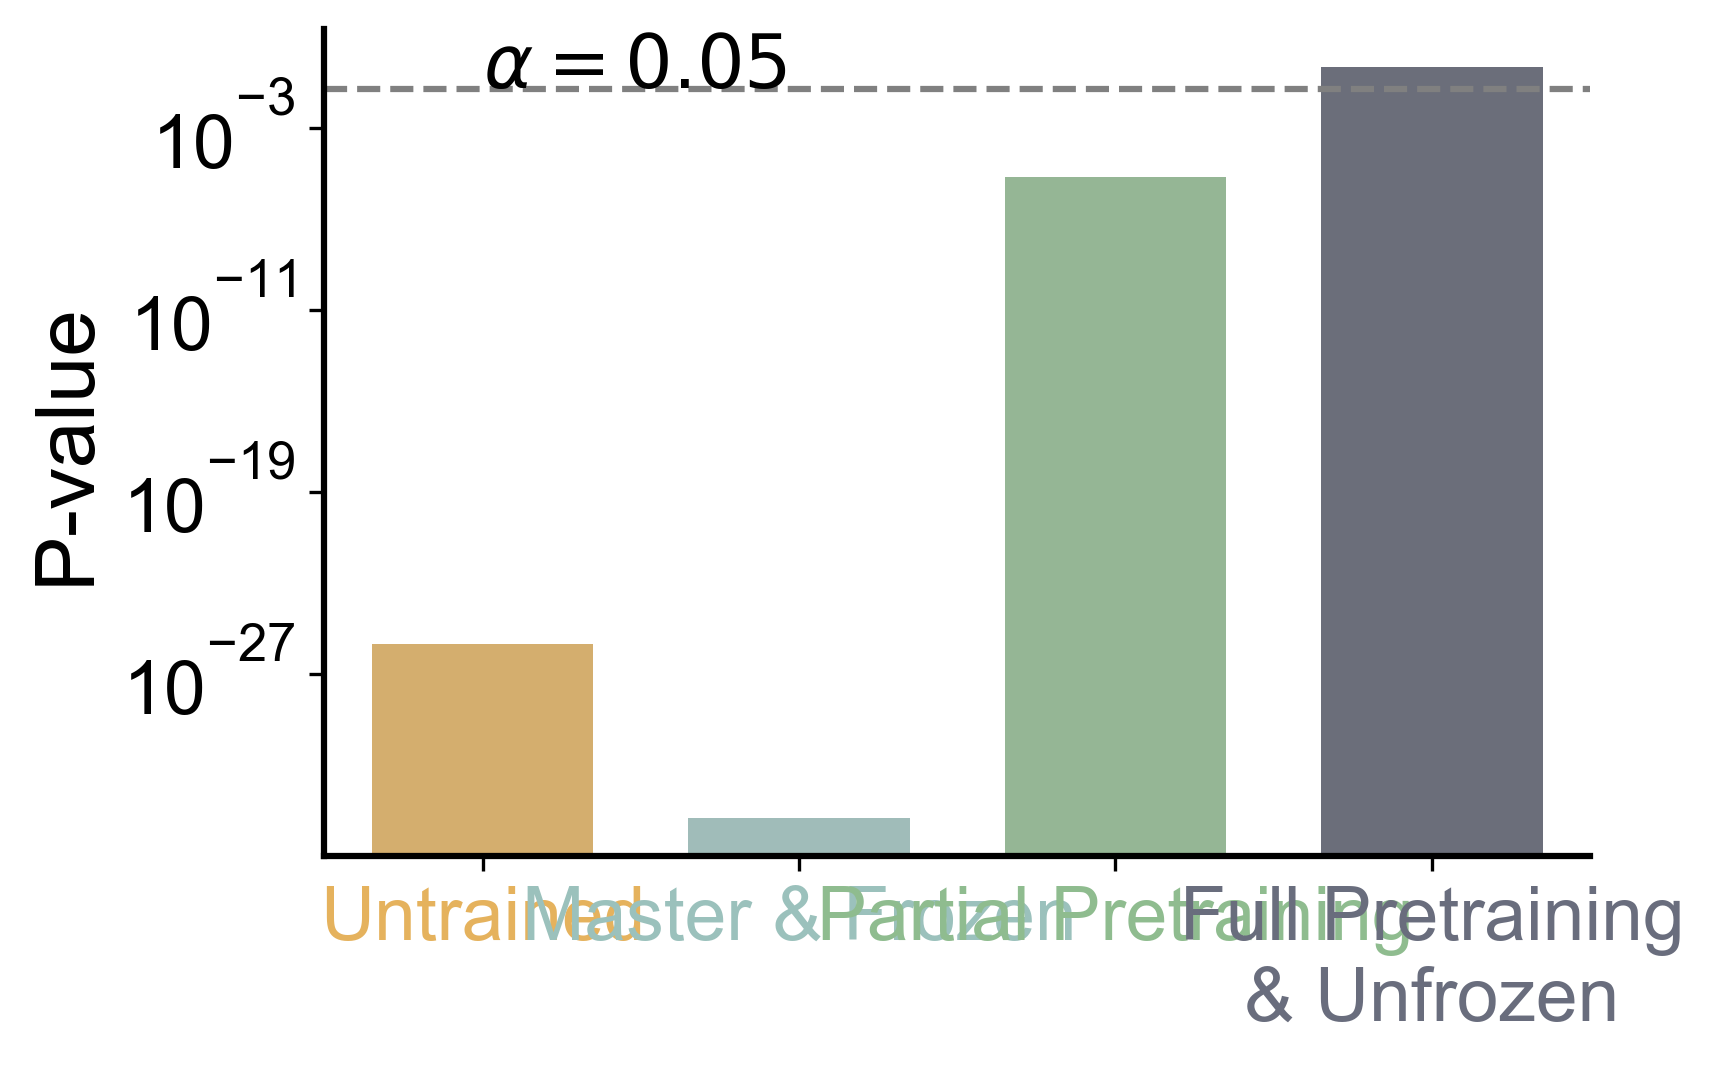

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_test, group_mapping_names, and color_mapping are defined as in the provided example

# Extract relevant comparisons where pretrain_frozen is involved
pretrain_frozen_comparisons = df_test[
    df_test["pairs"].apply(lambda x: "pretrain_frozen" in x)
]

# Create a dataframe for the bar plots
bar_data = pretrain_frozen_comparisons.copy()
bar_data["comparison"] = bar_data["pairs"].apply(
    lambda x: x[0] if x[1] == "pretrain_frozen" else x[1]
)

# Create a palette using your color mapping and rename groups using group_mapping_names
palette = {
    group_mapping_names[group]: color_mapping.get(group, "gray")
    for group in bar_data["comparison"].unique()
}

# Apply group name mapping to the comparison column
bar_data["comparison"] = bar_data["comparison"].map(group_mapping_names)

# Set up the plot with higher DPI for better quality
plt.figure(figsize=(6, 4), dpi=300)  # Increased DPI for better resolution

# Create the bar plot with reduced bar width
ax = sns.barplot(
    x="comparison",
    y="adjusted_p_value",
    data=bar_data,
    palette=palette,
    width=0.7,  # Reduce the width of the bars slightly to allow them to be closer
    dodge=False,  # Ensure no separation between bars for grouped data
)

# Set log scale for p-values
plt.yscale("log")

# Horizontal line at p-value threshold (0.05)
plt.axhline(y=0.05, color="grey", linestyle="--")

# Add text for \alpha = 0.05 using LaTeX formatting
plt.text(x=0, y=0.06, s=r"$\alpha = 0.05$", color="black")

# Set axis labels
plt.xlabel("")
plt.ylabel("P-value")

# Rotate x-axis labels and align with colors
plt.xticks(rotation=0)
for tick_label, color in zip(
    ax.get_xticklabels(), [palette[label.get_text()] for label in ax.get_xticklabels()]
):
    tick_label.set_color(color)

# Customize the plot appearance to remove all spines except the left and bottom
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(1.5)
ax.spines["bottom"].set_linewidth(1.5)

# Adjust the font size of the y-axis label for better readability

# Remove title and legend
plt.title("")
plt.legend().remove()

# Display the plot
plt.tight_layout()
plt.show()